In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [62]:
train_dir='./data/New Masks Dataset/Train/'
val_dir='./data/New Masks Dataset/Validation/'
test_dir='./data/New Masks Dataset/Test/'
batch_size=32

data_gen_args_base = dict(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False
)

# training data
train_data_generator = ImageDataGenerator(**data_gen_args_base)
train_set = train_data_generator.flow_from_directory(directory=train_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# validation data
val_data_generator = ImageDataGenerator(**data_gen_args_base)
val_set = val_data_generator.flow_from_directory(directory=val_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# test data
test_data_generator = ImageDataGenerator(**data_gen_args_base)
test_set = test_data_generator.flow_from_directory(directory=test_dir,
                                                    target_size=(128, 128),
                                                    batch_size=batch_size,
                                                    class_mode='binary')


Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


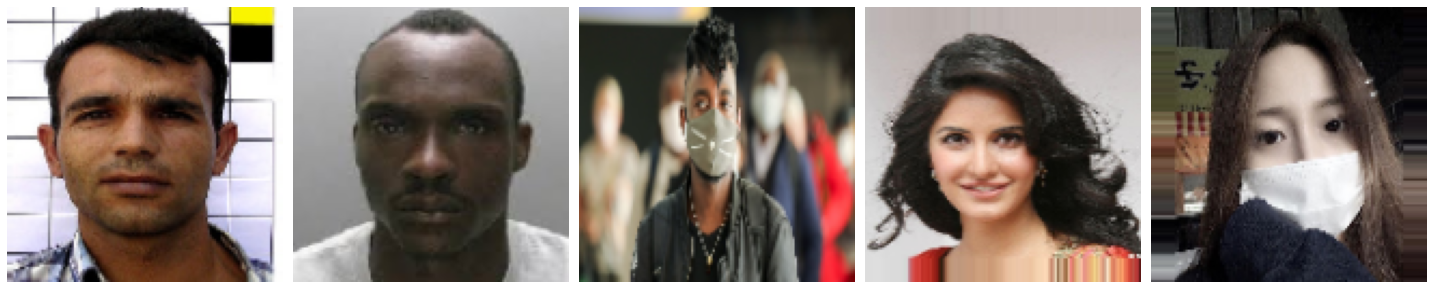

In [63]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_set)
plotImages(sample_training_images[:5])

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization

In [65]:
cnn = Sequential()
cnn.add(Conv2D(32, activation='relu', kernel_size=3, input_shape=[128,128,3]))
# https://www.quora.com/Why-does-batch-normalization-help
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, activation = 'relu', kernel_size = 3))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer='adam', metrics = 'accuracy', loss = 'binary_crossentropy')



In [66]:
cnn.fit(x=train_set, epochs=20, validation_data=val_set)

Epoch 1/20
19/19 [==============================] - 18s 963ms/step - loss: 5.3055 - accuracy: 0.7783 - val_loss: 0.7454 - val_accuracy: 0.5882
Epoch 2/20
19/19 [==============================] - 18s 950ms/step - loss: 4.0550 - accuracy: 0.8433 - val_loss: 5.3998 - val_accuracy: 0.5163
Epoch 3/20
19/19 [==============================] - 18s 933ms/step - loss: 3.1825 - accuracy: 0.8583 - val_loss: 8.3608 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 18s 933ms/step - loss: 3.4076 - accuracy: 0.8417 - val_loss: 15.1028 - val_accuracy: 0.5000
Epoch 5/20
19/19 [==============================] - 18s 938ms/step - loss: 2.9028 - accuracy: 0.8550 - val_loss: 11.4705 - val_accuracy: 0.5000
Epoch 6/20
19/19 [==============================] - 18s 926ms/step - loss: 2.1151 - accuracy: 0.8967 - val_loss: 3.8986 - val_accuracy: 0.5686
Epoch 7/20
19/19 [==============================] - 17s 918ms/step - loss: 1.8178 - accuracy: 0.8983 - val_loss: 14.9219 - val_accuracy: 0.5

In [67]:
result = cnn.evaluate(test_set)
dict(zip(cnn.metrics_names, result))

4/4 [==============================] - 1s 154ms/step - loss: 5.4757 - accuracy: 0.8400


{'loss': 5.475732803344727, 'accuracy': 0.8399999737739563}